# Retail Store Data

Import pandas, seaborn, and matplotlib.

In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from collections import Counter
%matplotlib inline

Read the train data.  

In [2]:
features = pd.read_csv("features.csv",
                     sep=",",  # delimiter
                     header=0, # header in first row
                     index_col=0 # ids in first column
                     )
sales = pd.read_csv("sales.csv",
                     sep=",",  # delimiter
                     header=0, # header in first row
                     index_col=0 # ids in first column
                     )


stores = pd.read_csv("stores.csv",
                     sep=",",  # delimiter
                     header=0, # header in first row
                     index_col=0 # ids in first column
                     )

We want to look at our data and see where the nulls are if there are any

In [3]:
features.describe(include="all",datetime_is_numeric=True)

,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
count,8190,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000,8190
unique,182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,05/02/2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7605
mean,NaN,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821,NaN
std,NaN,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259,NaN
min,NaN,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000,NaN
25%,NaN,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000,NaN
50%,NaN,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000,NaN
75%,NaN,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000,NaN


In [4]:
print(sales.tail())

       Dept        Date  Weekly_Sales  IsHoliday
Store                                           
45       98  28/09/2012        508.37      False
45       98  05/10/2012        628.10      False
45       98  12/10/2012       1061.02      False
45       98  19/10/2012        760.01      False
45       98  26/10/2012       1076.80      False


In [5]:
print(features.tail())

             Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
Store                                                                         
45     28/06/2013        76.05       3.639    4842.29     975.03       3.00   
45     05/07/2013        77.50       3.614    9090.48    2268.58     582.74   
45     12/07/2013        79.37       3.614    3789.94    1827.31      85.72   
45     19/07/2013        82.84       3.737    2961.49    1047.07     204.19   
45     26/07/2013        76.06       3.804     212.02     851.73       2.06   

       MarkDown4  MarkDown5  CPI  Unemployment  IsHoliday  
Store                                                      
45       2449.97    3169.69  NaN           NaN      False  
45       5797.47    1514.93  NaN           NaN      False  
45        744.84    2150.36  NaN           NaN      False  
45        363.00    1059.46  NaN           NaN      False  
45         10.88    1864.57  NaN           NaN      False  


In [6]:
print(stores.tail())

      Type    Size
Store             
41       A  196321
42       C   39690
43       C   41062
44       C   39910
45       B  118221


Convert dates to the correct data type

In [7]:
#Lets convert the dates to the right data type
features['Date'] = pd.to_datetime(features['Date'], format='%d/%m/%Y')
sales['Date'] = pd.to_datetime(sales['Date'], format='%d/%m/%Y')
#now lets make sure they converted correctly
print(features['Date'] ,sales['Date'])

Store
1    2010-02-05
1    2010-02-12
1    2010-02-19
1    2010-02-26
1    2010-03-05
        ...    
45   2013-06-28
45   2013-07-05
45   2013-07-12
45   2013-07-19
45   2013-07-26
Name: Date, Length: 8190, dtype: datetime64[ns] Store
1    2010-02-05
1    2010-02-12
1    2010-02-19
1    2010-02-26
1    2010-03-05
        ...    
45   2012-09-28
45   2012-10-05
45   2012-10-12
45   2012-10-19
45   2012-10-26
Name: Date, Length: 421570, dtype: datetime64[ns]


Lets begin making some observations on the current data

In [32]:

stores = stores.reset_index()

#I want to see overall how each store type is doing by data. We will need to do a groupby
sales_date_store = sales.groupby(["Date","Store"]).agg({"Weekly_Sales":"sum"})
sales_date_store.sort_index(inplace=True)
#lets convert our weekly_sales to a number that will be readable in the visualization (millions)
sales_date_store.Weekly_Sales = sales_date_store.Weekly_Sales/10000
#we won't need the cent amount so we can convert it from a float to an int
sales_date_store.Weekly_Sales = sales_date_store.Weekly_Sales.apply(int)
sales_date_store
'''
#since our store type is in the stores table and sales in the sales table we will need to do a merge
data_table = pd.merge(features,sales_date_store ,  how='left', on=["Date","Store"])
data_table = pd.merge(data_table,stores[["Store","Type"]] ,  how='left', on=["Store"])
data_table.head(20)
#we can now set our train and test variables
data_train = data_table[data_table.Weekly_Sales.notnull()]
data_test = data_table[data_table.Weekly_Sales.isnull()]
'''

'\n#since our store type is in the stores table and sales in the sales table we will need to do a merge\ndata_table = pd.merge(features,sales_date_store ,  how=\'left\', on=["Date","Store"])\ndata_table = pd.merge(data_table,stores[["Store","Type"]] ,  how=\'left\', on=["Store"])\ndata_table.head(20)\n#we can now set our train and test variables\ndata_train = data_table[data_table.Weekly_Sales.notnull()]\ndata_test = data_table[data_table.Weekly_Sales.isnull()]\n'

<AxesSubplot:xlabel='Date', ylabel='Weekly_Sales'>

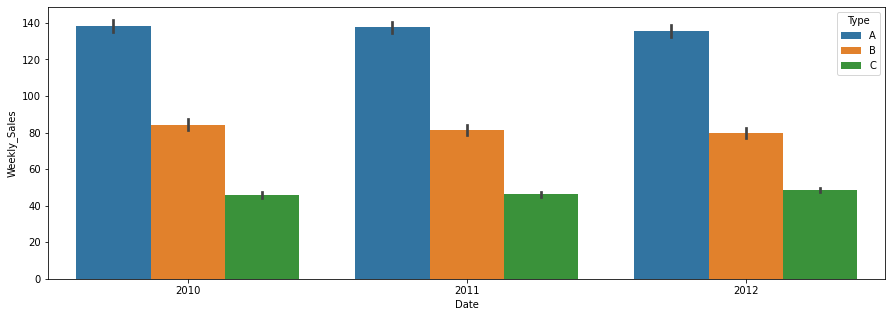

In [9]:
plt.figure(figsize=(15, 5))
sb.barplot(x=data_train.Date.dt.year, y=data_train.Weekly_Sales,hue=data_train.Type)

In [10]:
"""Store Type A & B has shown slight decrease year on basis in sales.
Store C has shown a slight increase in sales."""

'Store Type A & B has shown slight decrease year on basis in sales.\nStore C has shown a slight increase in sales.'

In [11]:
#now lets see how each store type is doing overall

#we must do a groupby on each store# and aggregate by the correct function for each column
data_Store = features.groupby("Store").agg({"Temperature":"mean","Fuel_Price":"mean","IsHoliday":"sum"})
temp_store = sales.groupby("Store").agg({"Weekly_Sales":"sum"})
#again converting our weekly sales into a readable number for our visualization
temp_store.Weekly_Sales = temp_store.Weekly_Sales/1000000
temp_store.Weekly_Sales = temp_store.Weekly_Sales.apply(int)
data_Store.set_index(np.arange(0,45),inplace=True)
stores["temp"] = data_Store.Temperature
stores["Fuel_Price"] = data_Store.Fuel_Price
stores["holiday"] = data_Store.IsHoliday
stores["Weekly_Sales"] = temp_store.Weekly_Sales

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Type', ylabel='Weekly_Sales'>

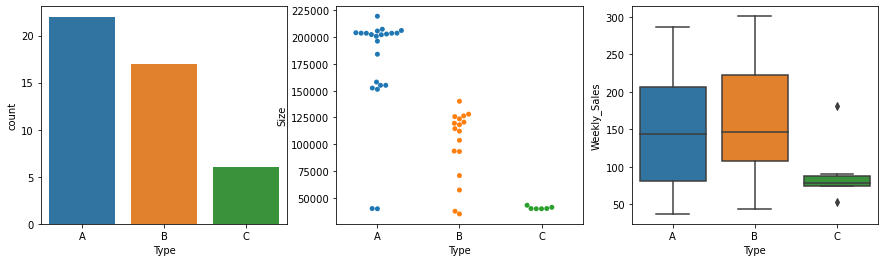

In [12]:
fig,ax = plt.subplots(1,3,figsize=(15, 4))
sb.countplot(stores.Type,ax=ax[0])
sb.swarmplot(data = stores,y="Size",x="Type",ax=ax[1])

sb.boxplot(data = stores,y="Weekly_Sales",x="Type",ax=ax[2])

In [13]:
'''Out of 45 total stores, Store Count is in the order of A, B and least is C
Size wise A store as most no of Item followed by B and than C
Even After less Count of Store and lesser Size B has more Weekly Sales than A and C at the least.'''

'Out of 45 total stores, Store Count is in the order of A, B and least is C\nSize wise A store as most no of Item followed by B and than C\nEven After less Count of Store and lesser Size B has more Weekly Sales than A and C at the least.'

In [14]:
'''
lets Merge Feature tables and sales tables based on the date
we will convert WeeklySales in Millions
we will modify column as the day is holiday or not
'''

data_date = features.groupby("Date").agg({"Temperature":"mean"
                                            ,"Fuel_Price":"mean"
                                            ,"IsHoliday":"sum"
                                            ,"CPI":"mean"
                                           ,"Unemployment":"mean"})
data_date = data_date.sort_index()
temp_date_data = data_date[:'2012-12-10']

data_sales_date = sales.groupby("Date").agg({"Weekly_Sales":"sum"})
data_sales_date.sort_index(inplace=True)
data_sales_date.Weekly_Sales = data_sales_date.Weekly_Sales/1000000
data_sales_date.Weekly_Sales = data_sales_date.Weekly_Sales.apply(int)
data = pd.merge(data_sales_date, temp_date_data, left_index=True,right_index=True, how='left')
data["IsHoliday"] = data["IsHoliday"].apply(lambda x: True if x == 45.0 else False )


<AxesSubplot:title={'center':'Unemployment'}, xlabel='Date'>

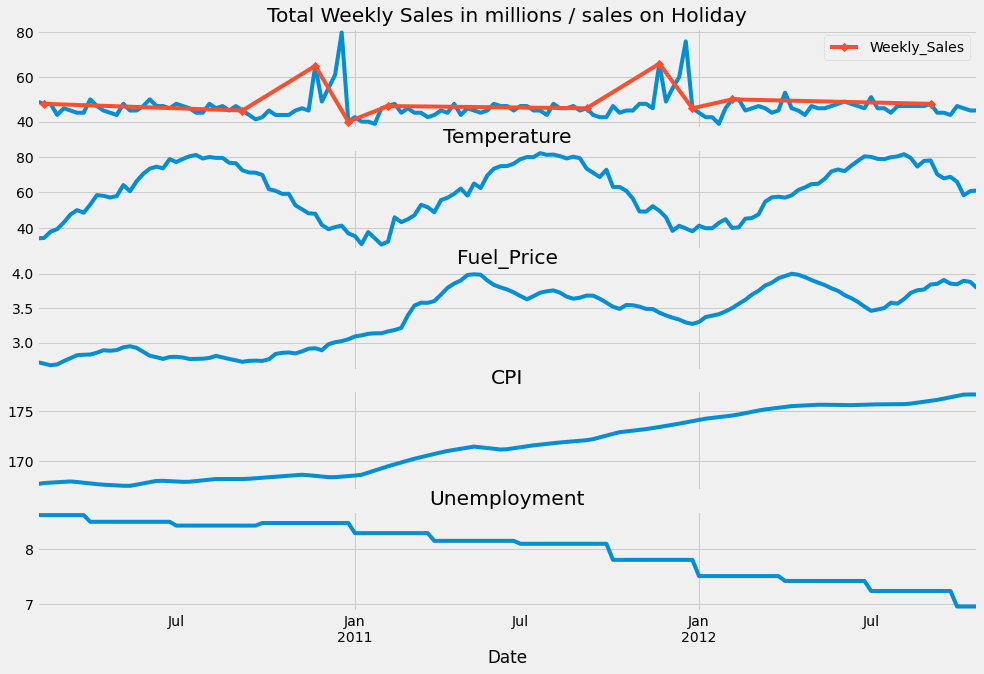

In [15]:
plt.style.use('fivethirtyeight')
#plt.figure(figsize=(15,4))
fig, ax = plt.subplots(5,1,figsize=(15,10),sharex=True) 
data["Weekly_Sales"].plot(ax=ax[0],title="Total Weekly Sales in millions / sales on Holiday")
data[data.IsHoliday==True]["Weekly_Sales"].plot(marker="D",ax=ax[0],legend="Holiday Week sale")
data["Temperature"].plot(ax=ax[1], title="Temperature")
data["Fuel_Price"].plot(ax=ax[2],title="Fuel_Price")
data["CPI"].plot(ax=ax[3],title="CPI")
data["Unemployment"].plot(ax=ax[4],title="Unemployment")


In [16]:
'''
Nov- Dec shows spike in Weekly Sales.but over the year it is not increased.
weeks nearby holiday shows peak
Fuel Price and Consumer Price Index shown growth over the year.
Unemployment decreased year after year.
Temperature is showing a random walk
'''

'\nNov- Dec shows spike in Weekly Sales.but over the year it is not increased.\nweeks nearby holiday shows peak\nFuel Price and Consumer Price Index shown growth over the year.\nUnemployment decreased year after year.\nTemperature is showing a random walk\n'

<AxesSubplot:>

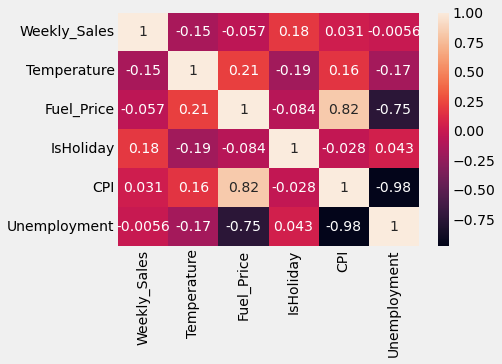

In [17]:
sb.heatmap(data.corr(),annot=True)

In [18]:
'''
Weekly sales doesnot show any high correlation with any other parameters.
CPI and Unemployment shows negative correlation on other hand Fuel Price show positive correlation
Unemployment and Fuel price are also negatively correlated
'''

'\nWeekly sales doesnot show any high correlation with any other parameters.\nCPI and Unemployment shows negative correlation on other hand Fuel Price show positive correlation\nUnemployment and Fuel price are also negatively correlated\n'

Text(0, 0.5, 'Sales (Million)')

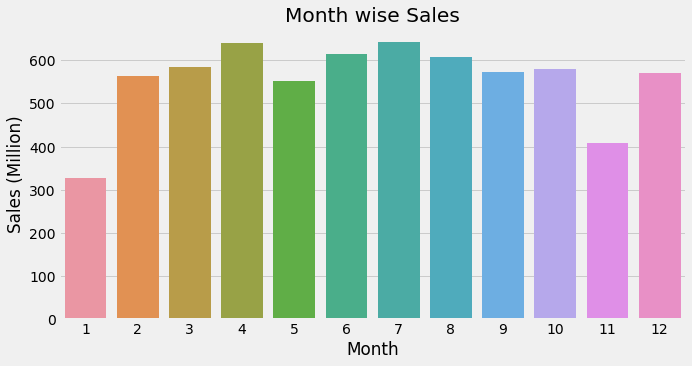

In [19]:
data_sales_month = data.groupby(data.index.month).agg({"Weekly_Sales":"sum"})
plt.figure(figsize=(10, 5))
sb.barplot(x=data_sales_month.index,y=data_sales_month.Weekly_Sales)
plt.title("Month wise Sales")
plt.xlabel("Month")
plt.ylabel("Sales (Million)")

In [20]:
'''
It could be as Enough buying during offer and holidays (Black friday Sales,Chrismas,New year) and later sales go down and then again gaining momentum in some months.
In Nov also people show less buying can be waiting period for upcoming sales.
whole data for Dec-2013 I guess is not available so even after spike in Dec the sales are not gone very high.
'''

'\nIt could be as Enough buying during offer and holidays (Black friday Sales,Chrismas,New year) and later sales go down and then again gaining momentum in some months.\nIn Nov also people show less buying can be waiting period for upcoming sales.\nwhole data for Dec-2013 I guess is not available so even after spike in Dec the sales are not gone very high.\n'

Text(0, 0.5, 'Sales')

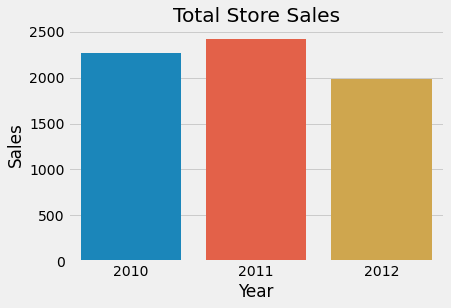

In [21]:
data_sales_year = data.groupby(data.index.year).agg({"Weekly_Sales":"sum"})

sb.barplot(x=data_sales_year.index,y=data_sales_year.Weekly_Sales)
plt.title("Total Store Sales")
plt.xlabel("Year")
plt.ylabel("Sales")

Now lets merge all of our tables

In [22]:
#first merge
retail_df=pd.merge(sales,features, on=['Store','Date', 'IsHoliday'], how='left')
#second_merge
retail_df=pd.merge(retail_df,stores, on=['Store'], how='left')
retail_df=retail_df.reset_index()
#Explanation below

Merge Explanation:
First, we want to match on the store#, date, and holiday since they are the same for each record in
both tables "sales" and "features" (becomes composite primary key in the merged table). We want to do a left join to include all records from the left table and only the matched records from the right because we want the records for each weekly_sales number in every department and this will also display our records with the nulls from the right table. We then want to add on the stores database by merging it onto the database I had just created "retail_df" with another left merge. This will ensure that all records are included from "retail_df" as well as assign a store type and size to each record.


Creating Aggregations for a more broad analysis & Writing out new csv DataFrames

In [23]:
#Now, I'm interested in Total Weekly_Sales by store rather than each specific department as well
#I want to do a groupby of store by Date and display the summed up Weekly Sales
sales = sales.reset_index()
store_total_sales = sales.groupby(["Store","Date"], as_index=False)['Weekly_Sales'].sum()
#convert into df
store_total_sales = pd.DataFrame(store_total_sales)
#rename to Total_Weekly_Sales which represents all department sales for that week
store_total_sales.rename(columns = {'Weekly_Sales':'Total_Weekly_Sales'}, inplace = True)
#lets now output it to a csv
totalsales_output = pd.DataFrame(store_total_sales)
totalsales_output.to_csv("total_sales_by_store.csv")

#now we have a new csv with the Total_Weekly_Sales info, so we can read it back in
storesales = pd.read_csv("total_sales_by_store.csv",
                     sep=",",  # delimiter
                     header=0, # header in first row
                     index_col=0 # ids in first column
                     )

#Now I want an overall idea of how my departments are doing across all stores each week
dept_total_sales = sales.groupby(["Dept","Date"], as_index=False)['Weekly_Sales'].sum()
#convert into df
dept_total_sales = pd.DataFrame(dept_total_sales)
#rename to Dept_Total_Sales which represents total sales for each department across all stores
#for that week
dept_total_sales.rename(columns = {'Weekly_Sales':'Dept_Total_Sales'}, inplace = True)
#lets now output it to a csv
deptsales_output = pd.DataFrame(dept_total_sales)
deptsales_output.to_csv("total_sales_by_dept.csv")

#now we have a new csv with the Dept_Total_Sales info, so we can read it back in
deptsales = pd.read_csv("total_sales_by_dept.csv",
                     sep=",",  # delimiter
                     header=0, # header in first row
                     index_col=0 # ids in first column
                       )
#storesales.head()
deptsales.head()

#these will both come in handy later on when we are doing our visualizations

,Dept,Date,Dept_Total_Sales
0,1,2010-02-05,881833.41
1,1,2010-02-12,1457182.40
2,1,2010-02-19,1118257.36
3,1,2010-02-26,681391.58
4,1,2010-03-05,762652.57


Convert categorical data to numerical, filling in missing data

In [24]:
#create new columns out of Date
retail_df["Month"] = retail_df.Date.dt.month
retail_df["Year"] = retail_df.Date.dt.year
retail_df["WeekofYear"] = retail_df.Date.dt.isocalendar().week
#retail_df.drop(['Date'],axis=1,inplace=True)

In [30]:
retail_df

,Store,Dept,Date,Weekly_Sales_x,IsHoliday,Temperature,Fuel_Price_x,MarkDown1,MarkDown2,MarkDown3,...,Unemployment,Type,Size,temp,Fuel_Price_y,holiday,Weekly_Sales_y,Month,Year,WeekofYear
0,1,1,2010-02-05,24924.50,1,42.31,2.572,0.00,0.00,0.00,...,8.106,0,151315,66.912033,3.259242,13,NaN,2,2010,5
1,1,1,2010-02-12,46039.49,0,38.51,2.548,0.00,0.00,0.00,...,8.106,0,151315,66.912033,3.259242,13,NaN,2,2010,6
2,1,1,2010-02-19,41595.55,1,39.93,2.514,0.00,0.00,0.00,...,8.106,0,151315,66.912033,3.259242,13,NaN,2,2010,7
3,1,1,2010-02-26,19403.54,1,46.63,2.561,0.00,0.00,0.00,...,8.106,0,151315,66.912033,3.259242,13,NaN,2,2010,8
4,1,1,2010-03-05,21827.90,1,46.50,2.625,0.00,0.00,0.00,...,8.106,0,151315,66.912033,3.259242,13,NaN,3,2010,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,1,64.88,3.997,4556.61,20.64,1.50,...,8.684,1,118221,56.256154,3.476412,13,43.0,9,2012,39
421566,45,98,2012-10-05,628.10,1,64.89,3.985,5046.74,0.00,18.82,...,8.667,1,118221,56.256154,3.476412,13,43.0,10,2012,40
421567,45,98,2012-10-12,1061.02,1,54.47,4.000,1956.28,0.00,7.89,...,8.667,1,118221,56.256154,3.476412,13,43.0,10,2012,41
421568,45,98,2012-10-19,760.01,1,56.47,3.969,2004.02,0.00,3.18,...,8.667,1,118221,56.256154,3.476412,13,43.0,10,2012,42


In [26]:
#Now, I'm interested in Total Weekly_Sales by store rather than each specific department as well
#I want to do a groupby of store by Date and display the summed up Weekly Sales
total_sales = retail_df.groupby(["Store","Date"], as_index=False)['Weekly_Sales'].sum()
#convert into df
total_sales = pd.DataFrame(total_sales)
total_sales.rename(columns = {'Weekly_Sales':'Total_Weekly_Sales'}, inplace = True)
totalsales_output = pd.DataFrame(total_sales)
totalsales_output.to_csv("total_sales_by_store.csv")
total_sales

KeyError: 'Column not found: Weekly_Sales'

In [27]:
'''
Since the data didn't come with explanations on everything, I assumed the Markdown columns to be a
representation of the dollar value of total markdowns sold for that particular week in different
categories (maybe clearance). Therefore, if the data had null values I assumed that it meant there
were no markdowns sold for that week and replaced nulls with 0.
'''
retail_df['MarkDown1'].fillna(0, inplace=True)
retail_df['MarkDown2'].fillna(0, inplace=True)
retail_df['MarkDown3'].fillna(0, inplace=True)
retail_df['MarkDown4'].fillna(0, inplace=True)
retail_df['MarkDown5'].fillna(0, inplace=True)

#CPI and unemployment should be replaced with average
retail_df['CPI'].fillna((retail_df['CPI'].mean()), inplace=True)
retail_df['Unemployment'].fillna((retail_df['Unemployment'].mean()), inplace=True)

retail_df['IsHoliday'] = retail_df['IsHoliday'].map({True:0,False:1})
types_encoded, types =retail_df['Type'].factorize()
retail_df['Type'] = types_encoded


In [28]:
del retail_df['index']
retail_df.head()

,Store,Dept,Date,Weekly_Sales_x,IsHoliday,Temperature,Fuel_Price_x,MarkDown1,MarkDown2,MarkDown3,...,Unemployment,Type,Size,temp,Fuel_Price_y,holiday,Weekly_Sales_y,Month,Year,WeekofYear
0,1,1,2010-02-05,24924.50,1,42.31,2.572,0.0,0.0,0.0,...,8.106,0,151315,66.912033,3.259242,13,NaN,2,2010,5
1,1,1,2010-02-12,46039.49,0,38.51,2.548,0.0,0.0,0.0,...,8.106,0,151315,66.912033,3.259242,13,NaN,2,2010,6
2,1,1,2010-02-19,41595.55,1,39.93,2.514,0.0,0.0,0.0,...,8.106,0,151315,66.912033,3.259242,13,NaN,2,2010,7
3,1,1,2010-02-26,19403.54,1,46.63,2.561,0.0,0.0,0.0,...,8.106,0,151315,66.912033,3.259242,13,NaN,2,2010,8
4,1,1,2010-03-05,21827.90,1,46.50,2.625,0.0,0.0,0.0,...,8.106,0,151315,66.912033,3.259242,13,NaN,3,2010,9


In [31]:
retail_df.rename(columns = {'Weekly_Sales_x':'Weekly_Sales'}, inplace = True)
retail_df.rename(columns = {'Fuel_Price_x':'Fuel_Price'}, inplace = True)
retail_df.rename(columns = {'Weekly_Sales_y':'Weekly_Sales'}, inplace = True)
retail_df.rename(columns = {'Fuel_Price_x':'Fuel_Price'}, inplace = True)
retail_df.describe()
#now our entire database columns have the expected counts of 42,1570

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price_x,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Unemployment,Type,Size,temp,Fuel_Price_y,holiday,Weekly_Sales_y,Month,Year,WeekofYear
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,...,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.0,411326.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,0.929642,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,...,7.960289,0.589912,136727.915739,58.823038,3.407146,13.0,151.827356,6.449510,2010.968591,25.826762
std,12.785297,30.492054,22711.183519,0.255750,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,...,1.863296,0.666337,60980.583328,9.749090,0.151280,0.0,78.477317,3.243217,0.796876,14.151887
min,1.000000,1.000000,-4988.940000,0.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,...,3.879000,0.000000,34875.000000,37.921264,3.245945,13.0,37.000000,1.000000,2010.000000,1.000000
25%,11.000000,18.000000,2079.650000,1.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,...,6.891000,0.000000,93638.000000,51.223516,3.259242,13.0,79.000000,4.000000,2010.000000,14.000000
50%,22.000000,37.000000,7612.030000,1.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,...,7.866000,0.000000,140167.000000,56.256154,3.328764,13.0,143.000000,6.000000,2011.000000,26.000000
75%,33.000000,74.000000,20205.852500,1.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,...,8.572000,1.000000,202505.000000,68.224505,3.497874,13.0,206.000000,9.000000,2012.000000,38.000000
max,45.000000,99.000000,693099.360000,1.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,...,14.313000,2.000000,219622.000000,75.438077,3.643654,13.0,301.000000,12.000000,2012.000000,52.000000


Create train and test datasets.

In [15]:
X = retail_df.drop(["Weekly_Sales"], axis=1)
y = retail_df["Weekly_Sales"]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=0,
)

NameError: name 'retail_df' is not defined

Fit logistic regression model and calculate accuracy using the train data.  Use 2000 for the maximum number of iterations.

In [18]:
my_lr = LogisticRegression(max_iter=2000).fit(X_train, y_train)
lr_pred_train = my_lr.predict(X_train)
metrics.accuracy_score(y_train, lr_pred_train)

0.9403865312996655

Calculate accuracy using the test data.



In [15]:
lr_pred_test = my_lr.predict(X_test)
metrics.accuracy_score(y_test, lr_pred_test)

0.94

Create a confusion matrix for the test data.

In [9]:
metrics.confusion_matrix(y_test, lr_pred_test)

NameError: name 'y_test' is not defined

Fit decision tree model and calculate accuracy on the train data.

Make predictions using test data.

Create a confusion matrix for the test data.